In [ ]:
!pip install transformers datasets torch

In [ ]:
!pip install Sastrawi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.9 MB/s eta 0:00:00


In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import nltk
import re
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import json
import emoji
import stanza
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import os

In [ ]:
# read stopwords-id.txt
with open('stopwords-id.txt', 'r') as f:
    stop_words = f.read().splitlines()
    stop_words = [word.strip() for word in stop_words]
    stop_words = [word for word in stop_words if word != '']
    stop_words = set(stop_words)
    stop_words = list(stop_words)


In [ ]:
len(stop_words)

759

In [ ]:
stop_words.append(['iya', 'nya', 'sih'])

In [ ]:
df = pd.read_csv('/content/mbg (3).csv')

In [ ]:
with open('combined_slang_words.txt', 'r', encoding='utf-8') as f:
    slang_words = json.load(f)

df_slang = pd.DataFrame(list(slang_words.items()), columns=['slang', 'formal'])

In [ ]:
df_slang

,slang,formal
0,@,di
1,abis,habis
2,ad,ada
3,adlh,adalah
4,afaik,as far as i know
...,...,...
1013,wkwkkw,tertawa
1014,ahokncc,ahok
1015,istaa,nista
1016,benarjujur,jujur


In [ ]:
df

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1972617357702119840,Mon Sep 29 23:54:33 +0000 2025,2,@tempodotco Bp @prabowo anda Presiden bgi Raky...,1972812273573146690,NaN,tempodotco,in,NaN,0,0,0,https://x.com/undefined/status/197281227357314...,1688663918099812353,NaN
1,1972642002329301470,Mon Sep 29 23:54:32 +0000 2025,0,@somexthread Terus jika keracunan gak ada mint...,1972812269454233608,NaN,somexthread,in,NaN,0,0,0,https://x.com/undefined/status/197281226945423...,1416022718340734979,NaN
2,1972812198646055275,Mon Sep 29 23:54:15 +0000 2025,0,ga kebayang setsuko dikasih maem MBG yng di ka...,1972812198646055275,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281219864605...,1684071416197685248,NaN
3,1972812170619662448,Mon Sep 29 23:54:09 +0000 2025,0,Problem yang muncul sekarang ada ketergesa-ges...,1972812170619662448,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281217061966...,39964465,NaN
4,1972811971419590950,Mon Sep 29 23:53:21 +0000 2025,27,Kalau mau dapur MBG berbenah agar lebih bersi...,1972811971419590950,https://pbs.twimg.com/media/G2DV92bbwAE8RWG.jpg,NaN,in,NaN,6,6,9,https://x.com/undefined/status/197281197141959...,23343960,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,1972604928972746922,Mon Sep 29 14:36:02 +0000 2025,0,@aniesbaswedan MBG disabotase sama anak abah,1972671716833841566,NaN,aniesbaswedan,in,NaN,0,0,0,https://x.com/undefined/status/197267171683384...,1149708641987002368,NaN
801,1972620082347163989,Mon Sep 29 14:35:37 +0000 2025,3,@NgkongRoses MBG Makanan Bikin Goblok,1972671611905196510,NaN,NgkongRoses,in,NaN,0,0,2,https://x.com/undefined/status/197267161190519...,1262257841748021252,NaN
802,1972671490433728913,Mon Sep 29 14:35:08 +0000 2025,0,Terlalu banyak konsumsi MSG - menyebabkan kebo...,1972671490433728913,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267149043372...,1957065747370573824,NaN
803,1972671382090609148,Mon Sep 29 14:34:42 +0000 2025,0,Bupati Rejang Lebong Provinsi Bengkulu Muhamma...,1972671382090609148,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267138209060...,423220305,NaN


In [ ]:
# Define the model from HuggingFace
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cpu


In [ ]:
# melabeli teks
results = sentiment_analyzer(df['full_text'].tolist())

# menambahkan label ke kolom label
df['label'] = [result['label'] for result in results]

# menambahkan score ke score
df['score'] = [result['score'] for result in results]

In [ ]:
df

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,score
0,1972617357702119840,Mon Sep 29 23:54:33 +0000 2025,2,@tempodotco Bp @prabowo anda Presiden bgi Raky...,1972812273573146690,NaN,tempodotco,in,NaN,0,0,0,https://x.com/undefined/status/197281227357314...,1688663918099812353,NaN,negative,0.996092
1,1972642002329301470,Mon Sep 29 23:54:32 +0000 2025,0,@somexthread Terus jika keracunan gak ada mint...,1972812269454233608,NaN,somexthread,in,NaN,0,0,0,https://x.com/undefined/status/197281226945423...,1416022718340734979,NaN,negative,0.997568
2,1972812198646055275,Mon Sep 29 23:54:15 +0000 2025,0,ga kebayang setsuko dikasih maem MBG yng di ka...,1972812198646055275,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281219864605...,1684071416197685248,NaN,negative,0.404110
3,1972812170619662448,Mon Sep 29 23:54:09 +0000 2025,0,Problem yang muncul sekarang ada ketergesa-ges...,1972812170619662448,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281217061966...,39964465,NaN,negative,0.975240
4,1972811971419590950,Mon Sep 29 23:53:21 +0000 2025,27,Kalau mau dapur MBG berbenah agar lebih bersi...,1972811971419590950,https://pbs.twimg.com/media/G2DV92bbwAE8RWG.jpg,NaN,in,NaN,6,6,9,https://x.com/undefined/status/197281197141959...,23343960,NaN,positive,0.993496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,1972604928972746922,Mon Sep 29 14:36:02 +0000 2025,0,@aniesbaswedan MBG disabotase sama anak abah,1972671716833841566,NaN,aniesbaswedan,in,NaN,0,0,0,https://x.com/undefined/status/197267171683384...,1149708641987002368,NaN,neutral,0.994364
801,1972620082347163989,Mon Sep 29 14:35:37 +0000 2025,3,@NgkongRoses MBG Makanan Bikin Goblok,1972671611905196510,NaN,NgkongRoses,in,NaN,0,0,2,https://x.com/undefined/status/197267161190519...,1262257841748021252,NaN,neutral,0.732750
802,1972671490433728913,Mon Sep 29 14:35:08 +0000 2025,0,Terlalu banyak konsumsi MSG - menyebabkan kebo...,1972671490433728913,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267149043372...,1957065747370573824,NaN,negative,0.997308
803,1972671382090609148,Mon Sep 29 14:34:42 +0000 2025,0,Bupati Rejang Lebong Provinsi Bengkulu Muhamma...,1972671382090609148,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267138209060...,423220305,NaN,neutral,0.998748


In [ ]:
df_copy = df.copy()

In [ ]:
df

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,score
0,1972617357702119840,Mon Sep 29 23:54:33 +0000 2025,2,@tempodotco Bp @prabowo anda Presiden bgi Raky...,1972812273573146690,NaN,tempodotco,in,NaN,0,0,0,https://x.com/undefined/status/197281227357314...,1688663918099812353,NaN,negative,0.996092
1,1972642002329301470,Mon Sep 29 23:54:32 +0000 2025,0,@somexthread Terus jika keracunan gak ada mint...,1972812269454233608,NaN,somexthread,in,NaN,0,0,0,https://x.com/undefined/status/197281226945423...,1416022718340734979,NaN,negative,0.997568
2,1972812198646055275,Mon Sep 29 23:54:15 +0000 2025,0,ga kebayang setsuko dikasih maem MBG yng di ka...,1972812198646055275,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281219864605...,1684071416197685248,NaN,negative,0.404110
3,1972812170619662448,Mon Sep 29 23:54:09 +0000 2025,0,Problem yang muncul sekarang ada ketergesa-ges...,1972812170619662448,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281217061966...,39964465,NaN,negative,0.975240
4,1972811971419590950,Mon Sep 29 23:53:21 +0000 2025,27,Kalau mau dapur MBG berbenah agar lebih bersi...,1972811971419590950,https://pbs.twimg.com/media/G2DV92bbwAE8RWG.jpg,NaN,in,NaN,6,6,9,https://x.com/undefined/status/197281197141959...,23343960,NaN,positive,0.993496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,1972604928972746922,Mon Sep 29 14:36:02 +0000 2025,0,@aniesbaswedan MBG disabotase sama anak abah,1972671716833841566,NaN,aniesbaswedan,in,NaN,0,0,0,https://x.com/undefined/status/197267171683384...,1149708641987002368,NaN,neutral,0.994364
801,1972620082347163989,Mon Sep 29 14:35:37 +0000 2025,3,@NgkongRoses MBG Makanan Bikin Goblok,1972671611905196510,NaN,NgkongRoses,in,NaN,0,0,2,https://x.com/undefined/status/197267161190519...,1262257841748021252,NaN,neutral,0.732750
802,1972671490433728913,Mon Sep 29 14:35:08 +0000 2025,0,Terlalu banyak konsumsi MSG - menyebabkan kebo...,1972671490433728913,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267149043372...,1957065747370573824,NaN,negative,0.997308
803,1972671382090609148,Mon Sep 29 14:34:42 +0000 2025,0,Bupati Rejang Lebong Provinsi Bengkulu Muhamma...,1972671382090609148,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267138209060...,423220305,NaN,neutral,0.998748


<Axes: xlabel='count', ylabel='label'>

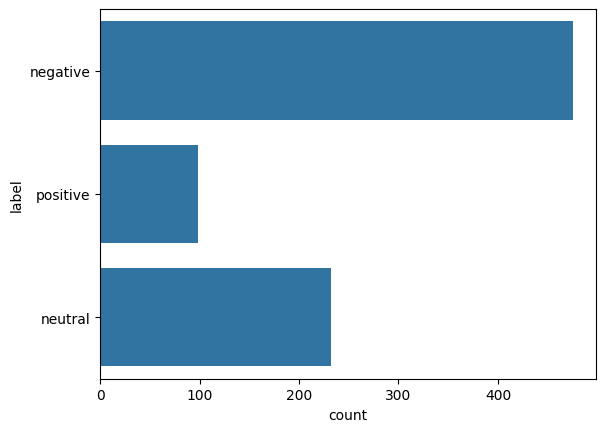

In [ ]:
sns.countplot(df['label'])

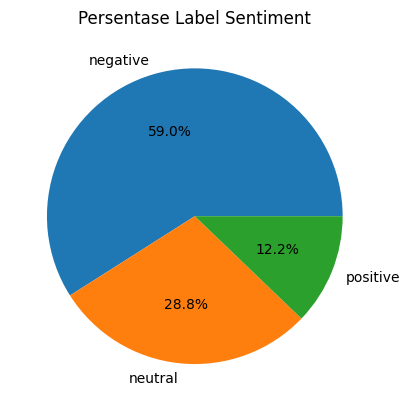

In [ ]:
# pie chart persentase label sentiment
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct='%1.1f%%')
plt.title('Persentase Label Sentiment')
plt.show()

In [ ]:
df[df['label'] == 'negative']

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,score
0,1972617357702119840,Mon Sep 29 23:54:33 +0000 2025,2,@tempodotco Bp @prabowo anda Presiden bgi Raky...,1972812273573146690,NaN,tempodotco,in,NaN,0,0,0,https://x.com/undefined/status/197281227357314...,1688663918099812353,NaN,negative,0.996092
1,1972642002329301470,Mon Sep 29 23:54:32 +0000 2025,0,@somexthread Terus jika keracunan gak ada mint...,1972812269454233608,NaN,somexthread,in,NaN,0,0,0,https://x.com/undefined/status/197281226945423...,1416022718340734979,NaN,negative,0.997568
2,1972812198646055275,Mon Sep 29 23:54:15 +0000 2025,0,ga kebayang setsuko dikasih maem MBG yng di ka...,1972812198646055275,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281219864605...,1684071416197685248,NaN,negative,0.404110
3,1972812170619662448,Mon Sep 29 23:54:09 +0000 2025,0,Problem yang muncul sekarang ada ketergesa-ges...,1972812170619662448,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281217061966...,39964465,NaN,negative,0.975240
6,1972494407808266586,Mon Sep 29 23:52:44 +0000 2025,1,@hiisunkissed @BernardRachmat @Musdali34805696...,1972811813499883649,NaN,hiisunkissed,in,NaN,0,1,0,https://x.com/undefined/status/197281181349988...,1876327133720748032,NaN,negative,0.559057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1972550244106928415,Mon Sep 29 14:36:52 +0000 2025,0,@liputan6dotcom Pak @prabowo tlg jgn mengecilk...,1972671928776155627,NaN,liputan6dotcom,in,NaN,0,0,0,https://x.com/undefined/status/197267192877615...,1585455260621234176,NaN,negative,0.996794
796,1972191033586045175,Mon Sep 29 14:36:49 +0000 2025,1,@sarah_pndjtn Kalau ga suka yang ga usah terim...,1972671914712998265,NaN,sarah_pndjtn,in,NaN,0,2,2,https://x.com/undefined/status/197267191471299...,4422544219,NaN,negative,0.997708
799,1972671722819035416,Mon Sep 29 14:36:03 +0000 2025,145,Anda kelihatannya ga peduli sama nasib anak² s...,1972671722819035416,https://pbs.twimg.com/ext_tw_video_thumb/19726...,NaN,in,NaN,9,34,58,https://x.com/undefined/status/197267172281903...,941458748,NaN,negative,0.998776
802,1972671490433728913,Mon Sep 29 14:35:08 +0000 2025,0,Terlalu banyak konsumsi MSG - menyebabkan kebo...,1972671490433728913,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267149043372...,1957065747370573824,NaN,negative,0.997308


In [ ]:
# fungsi untuk mengganti slang word menjadi kata normal
def slang_word_changer(text):
    text = text.split()
    tokens = [df_slang['formal'][df_slang['slang'] == word].values[0] if word in df_slang['slang'].values else word for word in text]
    return ' '.join(tokens)

In [ ]:
# mengganti slang word dengan kata normal
df_copy['no_slang'] = df_copy['full_text'].apply(slang_word_changer)

In [ ]:
df_copy

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,score,no_slang
0,1972617357702119840,Mon Sep 29 23:54:33 +0000 2025,2,@tempodotco Bp @prabowo anda Presiden bgi Raky...,1972812273573146690,NaN,tempodotco,in,NaN,0,0,0,https://x.com/undefined/status/197281227357314...,1688663918099812353,NaN,negative,0.996092,@tempodotco Bp @prabowo anda Presiden bgi Raky...
1,1972642002329301470,Mon Sep 29 23:54:32 +0000 2025,0,@somexthread Terus jika keracunan gak ada mint...,1972812269454233608,NaN,somexthread,in,NaN,0,0,0,https://x.com/undefined/status/197281226945423...,1416022718340734979,NaN,negative,0.997568,@somexthread Terus jika keracunan gak ada mint...
2,1972812198646055275,Mon Sep 29 23:54:15 +0000 2025,0,ga kebayang setsuko dikasih maem MBG yng di ka...,1972812198646055275,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281219864605...,1684071416197685248,NaN,negative,0.404110,ga kebayang setsuko dikasih makan MBG yng di k...
3,1972812170619662448,Mon Sep 29 23:54:09 +0000 2025,0,Problem yang muncul sekarang ada ketergesa-ges...,1972812170619662448,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197281217061966...,39964465,NaN,negative,0.975240,Problem yang muncul sekarang ada ketergesa-ges...
4,1972811971419590950,Mon Sep 29 23:53:21 +0000 2025,27,Kalau mau dapur MBG berbenah agar lebih bersi...,1972811971419590950,https://pbs.twimg.com/media/G2DV92bbwAE8RWG.jpg,NaN,in,NaN,6,6,9,https://x.com/undefined/status/197281197141959...,23343960,NaN,positive,0.993496,Kalau mau dapur MBG berbenah agar lebih bersih...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,1972604928972746922,Mon Sep 29 14:36:02 +0000 2025,0,@aniesbaswedan MBG disabotase sama anak abah,1972671716833841566,NaN,aniesbaswedan,in,NaN,0,0,0,https://x.com/undefined/status/197267171683384...,1149708641987002368,NaN,neutral,0.994364,@aniesbaswedan MBG disabotase sama anak abah
801,1972620082347163989,Mon Sep 29 14:35:37 +0000 2025,3,@NgkongRoses MBG Makanan Bikin Goblok,1972671611905196510,NaN,NgkongRoses,in,NaN,0,0,2,https://x.com/undefined/status/197267161190519...,1262257841748021252,NaN,neutral,0.732750,@NgkongRoses MBG Makanan Bikin Goblok
802,1972671490433728913,Mon Sep 29 14:35:08 +0000 2025,0,Terlalu banyak konsumsi MSG - menyebabkan kebo...,1972671490433728913,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267149043372...,1957065747370573824,NaN,negative,0.997308,Terlalu banyak konsumsi MSG - menyebabkan kebo...
803,1972671382090609148,Mon Sep 29 14:34:42 +0000 2025,0,Bupati Rejang Lebong Provinsi Bengkulu Muhamma...,1972671382090609148,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/197267138209060...,423220305,NaN,neutral,0.998748,Bupati Rejang Lebong Provinsi Bengkulu Muhamma...


In [ ]:
new_slang = {
    'gak':'tidak',
    'banget' : 'sangat',
    'emang': 'memang',
    'bikin' : 'membuat',
    'ga' : 'tidak'
}

In [ ]:
# mengganti kata dengan new slang
df_copy['no_slang'] = df_copy['no_slang'].apply(lambda x: ' '.join([new_slang[word] if word in new_slang else word for word in x.split()]))

In [ ]:
# fungsi untuk membersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # remove numeric
    text = re.sub(r'\d+', '', text)
    # remove link
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove mention
    text = re.sub(r'\@\w+', '', text)
    # handling emoji
    text = emoji.demojize(text, language='id')
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # translate semua kata menjadi bahasa indonesia
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

In [ ]:
# membersihkan teks dengan fungsi yang dibuat
df_copy['cleaned_text'] = df_copy['no_slang'].apply(clean_text)

In [ ]:
df_copy[['full_text', 'cleaned_text']]

,full_text,cleaned_text
0,@tempodotco Bp @prabowo anda Presiden bgi Raky...,bp presiden bgi rakyat ngr sjatinya lindungi n...
1,@somexthread Terus jika keracunan gak ada mint...,keracunan maaf klo meninggal akibat mbg pelaku...
2,ga kebayang setsuko dikasih maem MBG yng di ka...,kebayang setsuko dikasih makan mbg yng kabupat...
3,Problem yang muncul sekarang ada ketergesa-ges...,problem muncul ketergesagesaaan menjalankan ke...
4,Kalau mau dapur MBG berbenah agar lebih bersi...,dapur mbg berbenah bersih higienis kemarin tem...
...,...,...
800,@aniesbaswedan MBG disabotase sama anak abah,mbg disabotase anak abah
801,@NgkongRoses MBG Makanan Bikin Goblok,mbg makanan bikin goblok
802,Terlalu banyak konsumsi MSG - menyebabkan kebo...,konsumsi msg menyebabkan kebodohan diperdebatk...
803,Bupati Rejang Lebong Provinsi Bengkulu Muhamma...,bupati rejang lebong provinsi bengkulu muhamma...


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# tokenization
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

df_copy['tokenized_text'] = df_copy['cleaned_text'].apply(tokenize_text)

In [ ]:
df_copy['tokenized_text']

,tokenized_text
0,"[bp, presiden, bgi, rakyat, ngr, sjatinya, lin..."
1,"[keracunan, maaf, klo, meninggal, akibat, mbg,..."
2,"[kebayang, setsuko, dikasih, makan, mbg, yng, ..."
3,"[problem, muncul, ketergesagesaaan, menjalanka..."
4,"[dapur, mbg, berbenah, bersih, higienis, kemar..."
...,...
800,"[mbg, disabotase, anak, abah]"
801,"[mbg, makanan, bikin, goblok]"
802,"[konsumsi, msg, menyebabkan, kebodohan, diperd..."
803,"[bupati, rejang, lebong, provinsi, bengkulu, m..."


In [ ]:
# lemmatization
nlp = stanza.Pipeline('id', processors='tokenize,lemma')

def lemmatization(text):
    doc = nlp(' '.join(text))
    text = [word.lemma for sent in doc.sentences for word in sent.words]
    return text

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| lemma     | gsd_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
df_copy['lemmatized_text'] = df_copy['tokenized_text'].apply(lemmatization)

In [ ]:
df_copy['lemmatized_text']

,lemmatized_text
0,"[bp, presiden, bgi, rakyat, ngr, sjati, dia, l..."
1,"[racun, maaf, klo, tinggal, akibat, mbg, laku,..."
2,"[kebayang, setsuko, kasih, makan, mbg, yng, ka..."
3,"[problem, muncul, ketergesagesaaan, jalan, bij..."
4,"[dapur, mbg, benah, bersih, higienis, kemarin,..."
...,...
800,"[mbg, disabotase, anak, abah]"
801,"[mbg, makan, bikin, goblok]"
802,"[konsumsi, msg, sebab, kebodohan, debat, konsu..."
803,"[bupati, rejang, lebong, provinsi, bengkulu, m..."


In [ ]:
# join the text from stemmed_text
df_copy['final_text'] = df_copy['lemmatized_text'].apply(lambda x: ' '.join(x))

In [ ]:
# join the text from stemmed_text
df_copy['final_text'] = df_copy['tokenized_text'].apply(lambda x: ' '.join(x))

In [ ]:
df_copy['final_text']

,final_text
0,bp presiden bgi rakyat ngr sjatinya lindungi n...
1,keracunan maaf klo meninggal akibat mbg pelaku...
2,kebayang setsuko dikasih makan mbg yng kabupat...
3,problem muncul ketergesagesaaan menjalankan ke...
4,dapur mbg berbenah bersih higienis kemarin tem...
...,...
800,mbg disabotase anak abah
801,mbg makanan bikin goblok
802,konsumsi msg menyebabkan kebodohan diperdebatk...
803,bupati rejang lebong provinsi bengkulu muhamma...


In [ ]:
# menghapus kata dia, nya, iya
df_copy['final_text'] = df_copy['final_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in ['dia', 'nya', 'iya']]))

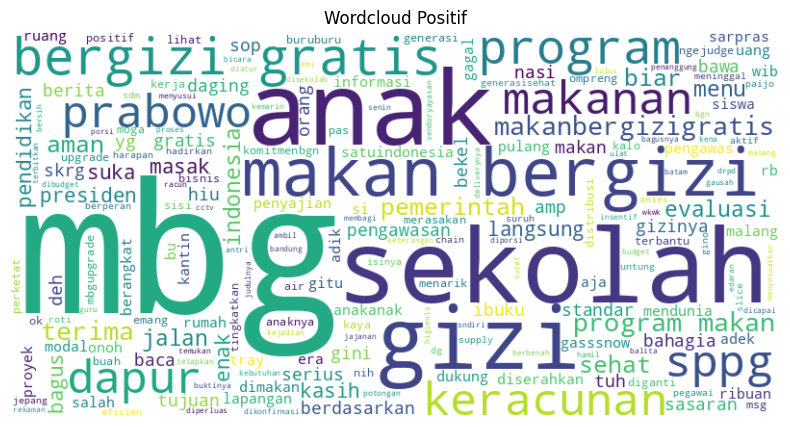

In [ ]:
# wordcloud per label
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_copy[df_copy['label'] == 'positive']['final_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Positif')
plt.show()

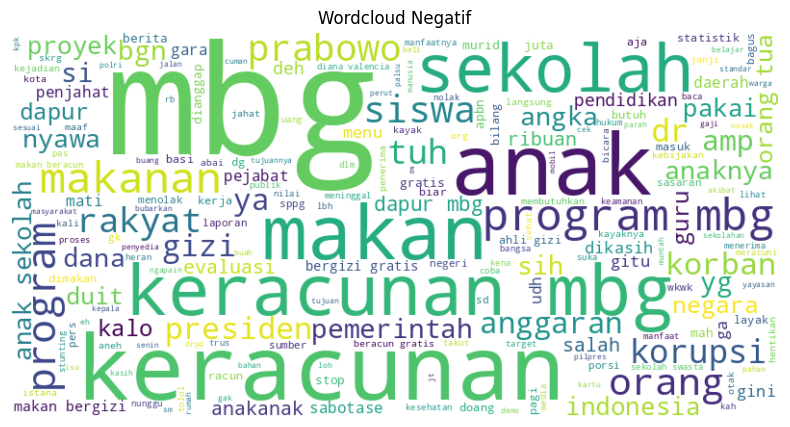

In [ ]:
# wordcloud for negative sentiment
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_copy[df_copy['label'] == 'negative']['final_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Negatif')
plt.show()

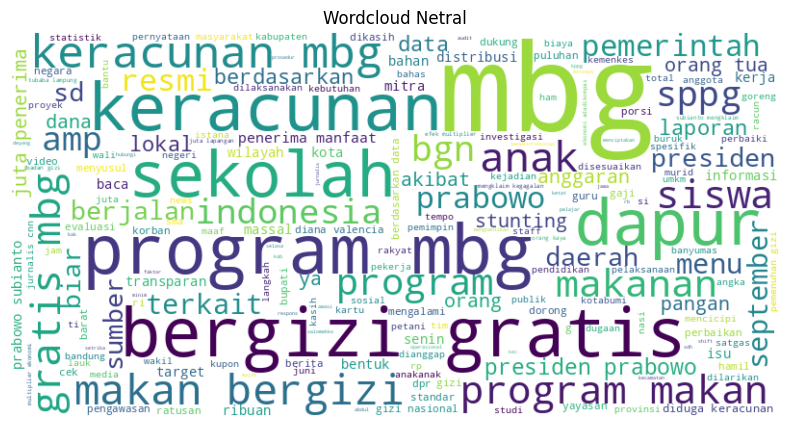

In [ ]:
# wordcloud for neutral sentiment
wordcloud_neu = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_copy[df_copy['label'] == 'neutral']['final_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Netral')
plt.show()

In [ ]:
# frekuensi per kata
def get_top_words(texts, n=10):
  all_words = " ".join(texts).split()
  counter = Counter(all_words)
  return counter.most_common(n)

In [ ]:
# frekuensi kata per sentimen
top_words_pos = get_top_words(df_copy[df_copy['label'] == 'positive']['final_text'])
top_words_neg = get_top_words(df_copy[df_copy['label'] == 'negative']['final_text'])

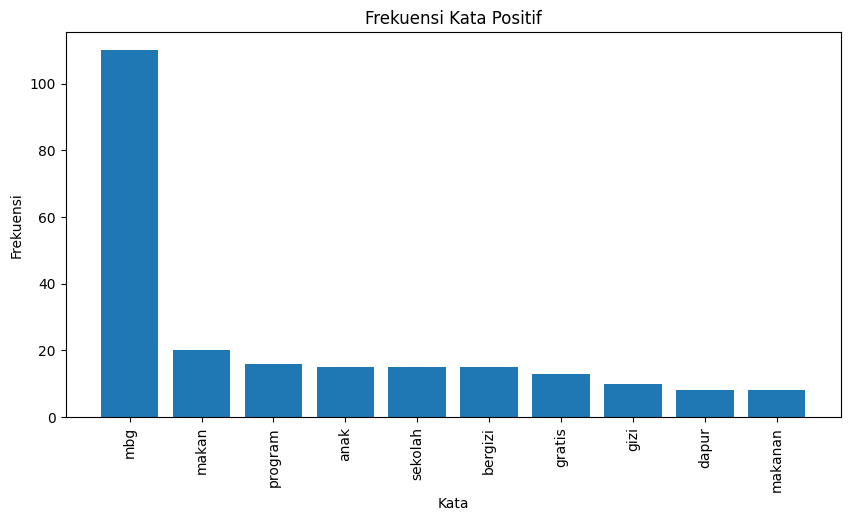

In [ ]:
# barplot frekuensi per kata
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_words_pos)), [freq for word, freq in top_words_pos])
plt.xticks(range(len(top_words_pos)), [word for word, freq in top_words_pos], rotation=90)
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Kata Positif')
plt.show()

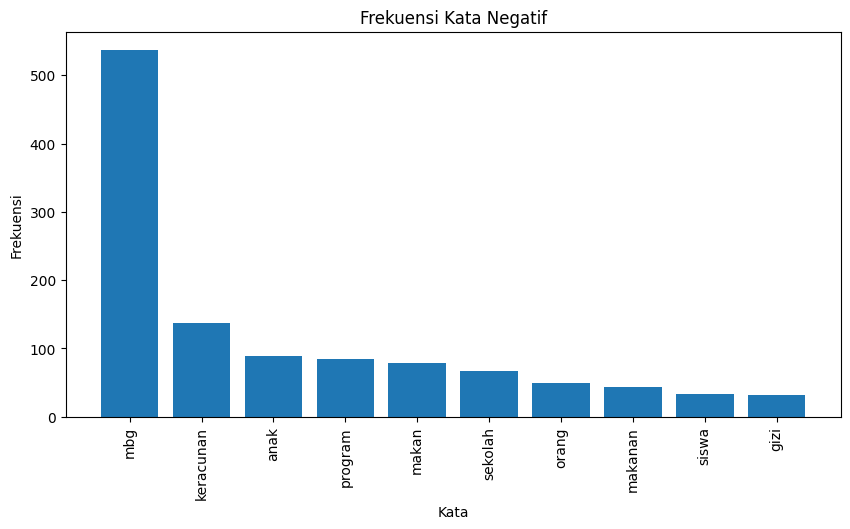

In [ ]:
# barplot frekuensi per kata
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_words_neg)), [freq for word, freq in top_words_neg])
plt.xticks(range(len(top_words_neg)), [word for word, freq in top_words_neg], rotation=90)
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Kata Negatif')
plt.show()

In [ ]:
top_words_pos

[('mbg', 110),
 ('makan', 20),
 ('program', 16),
 ('anak', 15),
 ('sekolah', 15),
 ('bergizi', 15),
 ('gratis', 13),
 ('gizi', 10),
 ('dapur', 8),
 ('makanan', 8)]

In [ ]:
top_words_neg

[('mbg', 537),
 ('keracunan', 137),
 ('anak', 89),
 ('program', 84),
 ('makan', 79),
 ('sekolah', 67),
 ('orang', 50),
 ('makanan', 44),
 ('siswa', 33),
 ('gizi', 32)]

In [ ]:
df_copy = df_copy[['final_text', 'label']]

In [ ]:
df_copy =  df_copy[df_copy['label'] != 'neutral']

In [ ]:
df_copy

,final_text,label
0,bp presiden bgi rakyat ngr sjatinya lindungi n...,negative
1,keracunan maaf klo meninggal akibat mbg pelaku...,negative
2,kebayang setsuko dikasih makan mbg yng kabupat...,negative
3,problem muncul ketergesagesaaan menjalankan ke...,negative
4,dapur mbg berbenah bersih higienis kemarin tem...,positive
...,...,...
796,suka terima mbg kasih anaknya makanan membutuh...,negative
798,yes air crucial produksi pangan laik sehat per...,positive
799,peduli nasib anak sekolahan keracunan mbg pakk...,negative
802,konsumsi msg menyebabkan kebodohan diperdebatk...,negative


In [ ]:
from sklearn.model_selection import train_test_split
# countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
# evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# label encoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
X = df_copy['final_text']
y = df_copy['label']

In [ ]:
# feature engineering
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [ ]:
# label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
# evaluation metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.8260869565217391
Precision: 0.6824196597353497
Recall: 0.8260869565217391
F1 score: 0.7474120082815735
